In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from dask.distributed import Client
import dask
import xarray as xr
import xgcm
from dask.diagnostics import ProgressBar
import sys
import matplotlib.patches as patches
sys.path.append('/homes/metofac/wenegrat/xroms/')
#sys.path.append('/homes/metofac/wenegrat/pyspec/')

#from xroms import open_roms_netcdf_dataset
import cmocean.cm as cmo
import xroms
#from pyspec import spectrum as spec
from scipy import integrate as integrate
from timeit import default_timer as timer

#%%
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 14
plt.rcParams['contour.negative_linestyle'] = 'solid'

import sys
sys.path.append("../../src/")
import load_model_runs as lruns

from importlib import reload  
import time

In [2]:
client = Client(memory_limit='20gb')
client

distributed.diskutils - INFO - Found stale lock file and directory '/data/pacific/jacob/CFB/cfb_on_ebf/notebooks/dask-worker-space/worker-8hi_hdyj', purging
distributed.diskutils - INFO - Found stale lock file and directory '/data/pacific/jacob/CFB/cfb_on_ebf/notebooks/dask-worker-space/worker-qm_yd_48', purging
distributed.diskutils - INFO - Found stale lock file and directory '/data/pacific/jacob/CFB/cfb_on_ebf/notebooks/dask-worker-space/worker-k1g1du38', purging
distributed.diskutils - INFO - Found stale lock file and directory '/data/pacific/jacob/CFB/cfb_on_ebf/notebooks/dask-worker-space/worker-ufb5nd6g', purging
distributed.diskutils - INFO - Found stale lock file and directory '/data/pacific/jacob/CFB/cfb_on_ebf/notebooks/dask-worker-space/worker-r67hc9vs', purging
distributed.diskutils - INFO - Found stale lock file and directory '/data/pacific/jacob/CFB/cfb_on_ebf/notebooks/dask-worker-space/worker-p4of8wm0', purging
distributed.diskutils - INFO - Found stale lock file and d

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 128,Total memory: 298.02 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38057,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 128
Started: Just now,Total memory: 298.02 GiB
Comm: tcp://127.0.0.1:36723,Total threads: 8
Dashboard: http://127.0.0.1:33138/status,Memory: 18.63 GiB
Nanny: tcp://127.0.0.1:45607,


In [5]:

def loadNewRun(filename, chunks, avg=False):
    # note here that filename should be the directory of history files
    from glob import glob

    
    if avg:
        files = sorted(glob(filename+'jet_avg.*.nc'))
    else:
        files = sorted(glob(filename+'jet_his.*.nc'))
    dsWC = xr.open_mfdataset(files, combine='nested', concat_dim='time', data_vars='minimal', chunks=chunks, coords='minimal', compat='override', parallel=True)

    #ds = xr.open_dataset('../data/model/jet_his.nc')

    # For some reason I have to correct the grid metrics that aren't being output with this CROCO run.
    #dsWC['s_rho'] = ('s_rho', ds.s_rho)
    #dsWC['s_w'] = ('s_w', ds.s_w)
    #dsWC['Cs_r'] = ds.Cs_r
    #dsWC['Cs_w'] = ds.Cs_w
    #dsWC['h'] = (('eta_rho', 'xi_rho'), 4000  + 0*dsWC.zeta.isel(time=0))
    #dsWC['pm'] = (('eta_rho', 'xi_rho'), 1/500 + 0*dsWC.zeta.isel(time=0))
    #dsWC['pn'] = (('eta_rho', 'xi_rho'), 1/500 + 0*dsWC.zeta.isel(time=0))
    #dsWC['pm_u'] = (('eta_rho', 'xi_u'), 1/500 + 0*dsWC.u.isel(time=0, s_rho=0))
    #dsWC['pn_v'] = (('eta_v', 'xi_rho'), 1/500 + 0*dsWC.v.isel(time=0, s_rho=0))

    #dsWC['f'] = dsNC.f ## XXX THIS IS A HACK THAT WON"T ALWAYS WORK
    #dsWC = dsWC.rename(time='ocean_time')
    print('here')
    dsWC, grid = xroms.roms_dataset(dsWC, Vtransform=1) ### IS THIS CORRECT???? NEED TO VERIFY!!
    print('and here')
    dsWC['rho'] = dsWC.temp
    dsWC = dsWC.swap_dims({'time':'ocean_time'})
    dsWC['temp'] = (-(1000+dsWC.rho)/(1000+dsWC.rho.isel(ocean_time=1, s_rho=-1).mean()) + 1)/2e-4 + 20
    return dsWC, grid

In [ ]:
chunks={'time':1, 'eta_rho':100, 'xi_rho':100, 'xi_u':100, 'eta_v':100, 's_rho':10, 's_w':10}
chunks={'time':1, 's_rho':10, 's_w':10}
chunks={'time':1, 's_rho':20, 's_w':20}
chunks={'time':1, 's_rho':5, 's_w':5}

runname = 'JET_NML_CFB'
dsWC, gridWC = loadNewRun('../data/model/'+runname+'/', chunks=chunks, avg=False)
dsWC

In [ ]:
destination = '../data/interim/'+runname+'/'

dst = dsWC
dst = dst.swap_dims({'ocean_time':'time'})
dst['buoyancy'] = xroms.buoyancy(dst.rho, rho0=dst.rho0)
nt = dst.ocean_time.size
for i in range(0, nt):
    tic = time.perf_counter()
    PV = dst.isel(time=i).xroms.ertel.compute()
    PVDS = PV.to_dataset()
    for variable in PVDS.variables.values():
            try:
                variable.attrs.pop('grid')
            except:
                dummy = []
    PVDS.to_netcdf(destination +f'pv_{i}.nc')
    toc = time.perf_counter()
    print(f'Processing step {i}/{nt} took: {(toc-tic)/60} min')

In [ ]:
runname

In [ ]:
dst = dsWC
grid = gridWC
hboundary = 'fill'
sboundary = 'extend'
dst = dst.swap_dims({'ocean_time':'time'})
dst['buoyancy'] = xroms.buoyancy(dst.rho, rho0=dst.rho0)
#buoyancy = buoyancy.swap_dims({'ocean_time': 'time'})
#PV = xroms.ertel(
#                buoyancy,
#                dst.u,
#                dst.v,
#                dst.f,
#                grid,
#                hcoord="rho",
#                scoord="s_rho",
#                hboundary=hboundary,
 #               hfill_value=None,
 #               sboundary=sboundary,
 #               sfill_value=None,)

PV = dst.isel(time=1).xroms.ertel

In [ ]:
#runname = 'JET_NML_NOCFB_BFLUX'

destination = '../data/interim/'+runname+'/'


In [ ]:
destination = '../data/interim/'+runname+'/'
PVDS = PV.to_dataset()
for variable in PVDS.variables.values():
            try:
                variable.attrs.pop('grid')
            except:
                print('No grid')
PVDS.to_netcdf(destination +'pv_1.nc')

In [ ]:
destination = '../data/interim/'+runname+'/'
PVDS = PV.to_dataset()
PVDS.to_zarr(destination +'pv_1.zarr')

In [ ]:
PV

In [ ]:
dsWC.xroms.ertel

In [ ]:
PV.isel(time=0, s_rho=-1, eta_rho=slice(0, 500), xi_rho=slice(0,500))

In [ ]:
PV.isel(time=0, s_rho=-1)

In [ ]:
relvort = dsWC.xroms.vort
relvort.isel(ocean_time=0, s_w = slice(-1)).compute()

## LOAD AND CHECK A RUN

In [14]:
#dstemp = dsWC.copy()
runname = 'JET_NML_CFB'

chunks={'time':1}#,'s_rho':10,'eta_rho':1002, 'xi_rho':1002}
#chunks = {'time':1, 'eta_rho':500,'xi_rho':500, 's_rho':1}
dsWC, gridWC = loadNewRun('../../data/model/'+runname+'/', chunks=chunks, avg=False)
runname = 'JET_NML_NOCFB'

dsNC, gridNC = loadNewRun('../../data/model/'+runname+'/', chunks=chunks, avg=False)

destination = '../../data/interim/'+runname+'/'

dspv_CFB = xr.open_mfdataset(destination + 'pv*.nc', combine='nested', concat_dim='time',chunks=chunks, data_vars='minimal', coords='minimal', compat='override', parallel=True)
dstemp = dsWC.swap_dims({'ocean_time':'time'})
dstemp = dstemp.chunk(chunks)
#rhoVol = dstemp.dz*dstemp.dx*dstemp.dy
#rhoVol = rhoVol.chunk(chunks)

here
and here
here
and here


In [15]:
runname = 'JET_NML_CFB_BFLUX'
runname = 'JET_NML_CFB'

destination = '../../data/interim/'+runname+'/'
#chunks = {'time':1, 'eta_rho':500,'xi_rho':500, 's_rho':1}
dspv_CFB = xr.open_mfdataset(destination + 'pv*.nc', combine='nested', concat_dim='time',chunks=chunks, data_vars='minimal', coords='minimal', compat='override', parallel=True)
#dspv_CFB = dspv_CFB.isel(eta_rho=slice(500, 3500))
ertelV = (dspv_CFB.ertel*dstemp.dz0).isel(s_rho=slice(63,100))
yl = slice(400, 4002-400)
nt = dspv_CFB.time.size
VIPV_CFB = np.zeros((31,))
for i in range(0, 31, 1):
    print(i,end="\r")
    #VIPV_CFB[i] = (dspv_CFB.isel(time=i).ertel*dstemp.isel(time=i).dz).sum( 'eta_rho').compute().sum(('xi_rho','s_rho')).compute()
    #VIPV_CFB[i] = (dspv_CFB.sel(time=dstemp.isel(time=i).time).ertel*dstemp.isel(time=i).dz).sum(('xi_rho','s_rho')).compute().isel(eta_rho=slice(500,3500)).sum()
    VIPV_CFB[i] = ertelV.sel(time=dstemp.isel(time=i).time).sum(('xi_rho','s_rho')).compute().isel(eta_rho=yl).sum()

#dspv_CFB.close()


KeyboardInterrupt



In [ ]:
runname = 'JET_NML_NOCFB_BFLUX'
runname = 'JET_NML_NOCFB'

destination = '../../data/interim/'+runname+'/'
#chunks = {'time':1, 'eta_rho':500,'xi_rho':500 , 's_rho':5}
dspv_NOCFB = xr.open_mfdataset(destination + 'pv*.nc', combine='nested', concat_dim='time',chunks=chunks, data_vars='minimal', coords='minimal', compat='override', parallel=True)
#dspv_NOCFB = dspv_NOCFB.isel(eta_rho=slice(500, 3500))
#ertelV = dspv_NOCFB.ertel*dstemp.dz0
ertelV = (dspv_NOCFB.ertel*dstemp.dz0).isel(s_rho=slice(63,100))


nt = dspv_NOCFB.time.size
VIPV_NOCFB = np.zeros((np.min([31, nt]),))
for i in range(0, np.min([31, nt]), 1):
    print(i, end="\r")
    #VIPV_NOCFB[i] = dspv_NOCFB.isel(time=i).ertel.sum( 'eta_rho').compute().sum(('xi_rho','s_rho')).compute()
    #VIPV_NOCFB[i] = (dspv_NOCFB.sel(time=dstemp.isel(time=i).time).ertel*dstemp.isel(time=i).dz).sum(('xi_rho','s_rho')).compute().isel(eta_rho=slice(500,3500)).sum()
    VIPV_NOCFB[i] = ertelV.sel(time=dstemp.isel(time=i).time).sum(('xi_rho','s_rho')).compute().isel(eta_rho=yl).sum()

#dspv_NOCFB.close()

In [3]:
runname = 'JET_NML_NOCFB'

destination = '../../data/interim/'+runname+'/'
chunks = {'time':1, 'eta_rho':1000, 's_rho':5}
dspv_NOCFB = xr.open_mfdataset(destination + 'pv*.nc', combine='nested', concat_dim='time',chunks=chunks, data_vars='minimal', coords='minimal', compat='override', parallel=True)
dspv_NOCFB

runname = 'JET_NML_CFB'
destination = '../../data/interim/'+runname+'/'
chunks = {'time':1, 'eta_rho':1000, 's_rho':5}
dspv_CFB = xr.open_mfdataset(destination + 'pv*.nc', combine='nested', concat_dim='time',chunks=chunks, data_vars='minimal', coords='minimal', compat='override', parallel=True)
dspv_CFB

<xarray.Dataset>
Dimensions:     (xi_rho: 1002, eta_rho: 4002, s_rho: 100, time: 42)
Coordinates:
  * xi_rho      (xi_rho) int64 0 1 2 3 4 5 6 7 ... 995 996 997 998 999 1000 1001
  * eta_rho     (eta_rho) int64 0 1 2 3 4 5 6 ... 3996 3997 3998 3999 4000 4001
  * s_rho       (s_rho) float32 -0.995 -0.985 -0.975 ... -0.025 -0.015 -0.005
    x_rho       (eta_rho, xi_rho) float32 dask.array<chunksize=(1000, 1002), meta=np.ndarray>
    y_rho       (eta_rho, xi_rho) float32 dask.array<chunksize=(1000, 1002), meta=np.ndarray>
    ocean_time  float64 ...
  * time        (time) float64 3.11e+07 3.119e+07 ... 3.18e+07 3.188e+07
    z_rho       (s_rho, eta_rho, xi_rho) float64 dask.array<chunksize=(5, 1000, 1002), meta=np.ndarray>
    z_rho0      (s_rho, eta_rho, xi_rho) float64 dask.array<chunksize=(5, 1000, 1002), meta=np.ndarray>
Data variables:
    ertel       (time, s_rho, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 5, 1000, 1002), meta=np.ndarray>

In [8]:
runname = 'JET_NML_CFB_BFLUX'
runname = 'JET_NML_CFB'

chunks={'time':1}
#chunks = {'time':1, 'eta_rho':500,'xi_rho':500, 's_rho':1}
dsWC, gridWC = loadNewRun('../../data/model/'+runname+'/', chunks=chunks, avg=False)
runname = 'JET_NML_NOCFB_BFLUX'
runname = 'JET_NML_NOCFB'

dsNC, gridNC = loadNewRun('../../data/model/'+runname+'/', chunks=chunks, avg=False)

# Calculate the EBF
bx = xroms.to_rho(-9.8/1020*gridWC.derivative(dsWC.rho.isel(s_rho=-1), 'X'), gridWC)
by = xroms.to_rho(-9.8/1020*gridWC.derivative(dsWC.rho.isel(s_rho=-1), 'Y'), gridWC)
dsWC['bx'] = bx
dsWC['by'] = by
dsWC['EBF'] = ((bx*xroms.to_rho(dsWC.svstr, gridWC) - by*xroms.to_rho(dsWC.sustr, gridWC))/(dsWC.f*1020)).compute()
dsWC['EBFm'] = (bx*1e-3*7*5 - by*1e-3*7*5)/(dsWC.f*1020)
dsWC['Nablab'] = np.sqrt(bx**2 + by**2)

bx = xroms.to_rho(-9.8/1020*gridNC.derivative(dsNC.rho.isel(s_rho=-1), 'X'), gridNC)
by = xroms.to_rho(-9.8/1020*gridNC.derivative(dsNC.rho.isel(s_rho=-1), 'Y'), gridNC)
dsNC['bx'] = bx
dsNC['by'] = by
dsNC['EBF'] = ((bx*xroms.to_rho(dsNC.svstr, gridNC) - by*xroms.to_rho(dsNC.sustr, gridNC))/(dsNC.f*1020)).compute()
dsNC['Nablab'] = np.sqrt(bx**2 + by**2)

here
and here
here
and here



KeyboardInterrupt



In [ ]:
print('done')

PV ratio:1.3426551812322625 


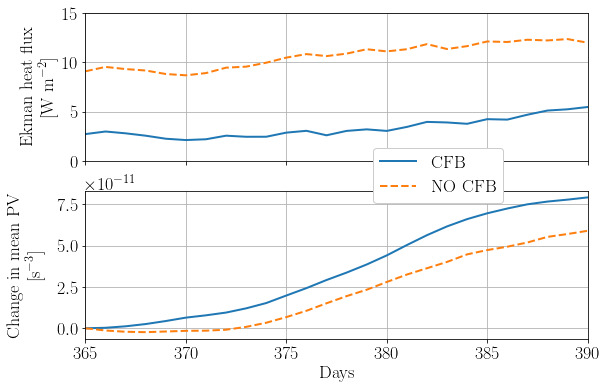

In [26]:
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 18
plt.rcParams['contour.negative_linestyle'] = 'solid'

fig, ax = plt.subplots(2,1, figsize=(9,6), sharex=True)
startdate = 5
normPV = 200*1002*3000
ax[1].plot(dstemp.time[startdate:len(VIPV_CFB)]/86400, (VIPV_CFB[startdate:]-VIPV_CFB[startdate])/normPV, linewidth=2, label='CFB')
ax[1].plot(dstemp.time[startdate:len(VIPV_NOCFB)]/86400, (VIPV_NOCFB[startdate:]-VIPV_NOCFB[startdate])/normPV, label='NO CFB', linestyle='--', linewidth=2)
ax[1].grid()
ax[1].set_ylabel('Change in mean PV\n [s$^{-3}$]', labelpad=12)
#ax[1].set_ylim(-1e-11, 0.9e-10)
btowatts=(1020*4000)/(2e-4*9.8)

ax[0].plot(dsWC.time[startdate:]/86400, btowatts*dsWC.EBF.isel(eta_rho=slice(1500, 2500)).mean(('eta_rho', 'xi_rho'))[startdate:], linewidth=2, label='CFB')
ax[0].plot(dsNC.time[startdate:]/86400, btowatts*dsNC.EBF.isel(eta_rho=slice(1500, 2500)).mean(('eta_rho', 'xi_rho'))[startdate:], label='NO CFB', linestyle='--', linewidth=2)
ax[0].grid()
ax[0].set_ylabel('Ekman heat flux\n [W m$^{-2}$]')
ax[0].set_ylim(0, 15)
ax[1].legend(bbox_to_anchor=(0.85, 1.35), ncol=1, framealpha=1)

ax[1].set_xlim(365, 390)
ax[1].set_xlabel('Days')

print(f'PV ratio:{(VIPV_CFB[-1]-VIPV_CFB[startdate])/(VIPV_NOCFB[-1]-VIPV_NOCFB[startdate])} ')
#plt.savefig(f'../figures/DeltaPV_{runname}.pdf', bbox_inches='tight')

-324.2277079341679


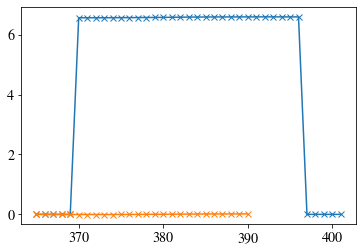

In [11]:
sortp = np.argsort(dspv_CFB.time)
pvsort_cfb = VIPV_CFB[sortp]

startind = 5
plt.plot(dspv_CFB.time.values[sortp][startind:]/86400, pvsort_cfb[startind:] - pvsort_cfb[startind], marker='x')
sortp = np.argsort(dspv_NOCFB.time.values)
pvsort_nocfb = VIPV_NOCFB[sortp]
plt.plot(dspv_NOCFB.time.values[sortp][startind:]/86400, pvsort_nocfb[startind:] - pvsort_nocfb[startind], marker='x')


print(( pvsort_cfb[-1] - pvsort_cfb[10])/(pvsort_nocfb[-1] - pvsort_nocfb[10]))

In [ ]:
dspv_CFB.hbl.mean().plot()

In [ ]:
dspv_CFB